In [1]:
import cv2
import numpy as np
from numpy import save
import math as m
import matplotlib.pyplot as plt
import os
from scipy.io import savemat
import scipy.io
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from scipy import signal
from scipy import stats
from numpy import moveaxis
from numpy import asarray
import torch
from scipy.stats import multivariate_normal
import torchvision
from torch.linalg import multi_dot
from HyperParameters import *
from Functions import *
from matplotlib import cm


In [2]:
refKey = torch.tensor([[0.4, 0.4, 0]
                       ,[0.4, 0.6, 0]
                       ,[0.6, 0.6, 0]
                       ,[0.6, 0.4, 0]], device=DEVICE, dtype=torch.double)


imgRef = torchvision.io.read_image(PathImg1)

height, width = 480, 640

In [3]:
tarKey = torch.tensor(np.load(PathNPY2), device=DEVICE)

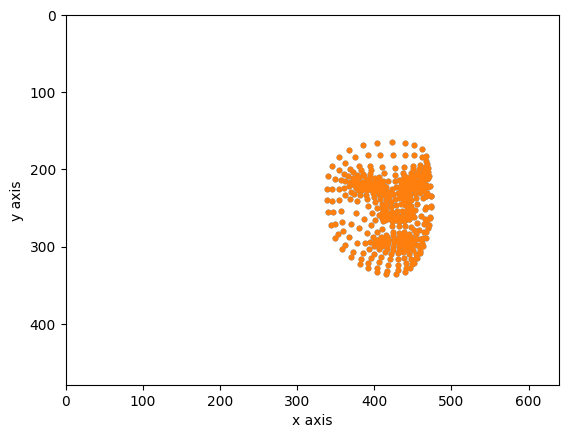

In [4]:
draw(width, height, tarKey, tarKey, size=10, connect=False)

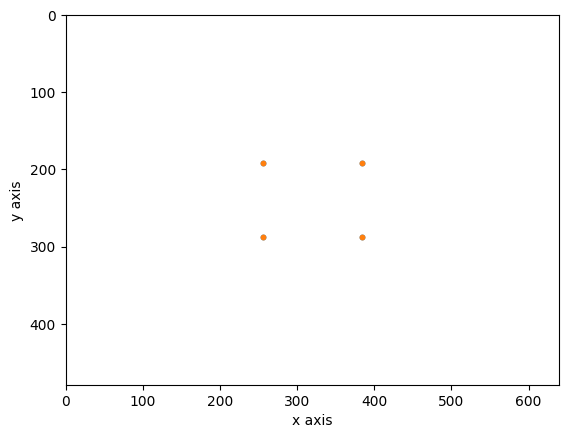

In [5]:
draw(width, height, refKey, refKey, size=10, connect=False)

In [16]:
T = torch.tensor([0.0, 0.0, 0.0], device=DEVICE)
# T = -torch.mean(refKey, axis=0) + torch.tensor([0.5, 0.5, 0], device=DEVICE)
euler = torch.tensor([0, 0, pi/2], device=DEVICE, dtype=torch.double)

newKeys = TransformKeys(refKey, euler, T)

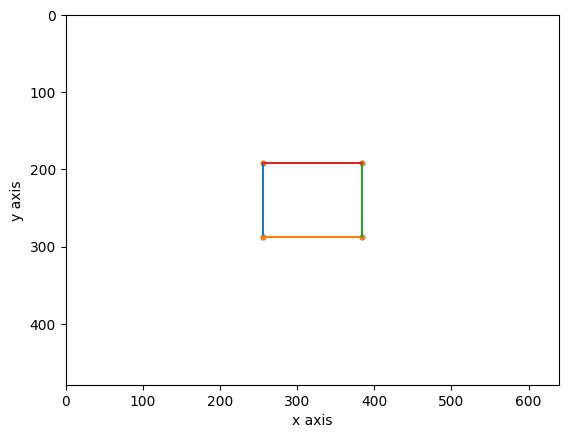

In [17]:
draw(width, height, refKey, newKeys, size=10, connect=True)

In [18]:
# dKey = refKey - newKeys
dKey = newKeys - refKey



sd=0.01
flowX, flowY = dKey[:,0], dKey[:,1]
d1 = torch.linspace(0, 1, height, device=DEVICE)
d2 = torch.linspace(0, 1, width, device=DEVICE)

# meshx, meshy = torch.meshgrid(d1, d2, indexing='ij') 
meshy, meshx = torch.meshgrid(d1, d2, indexing='ij')
# mx = meshx.clone()
# my = meshy.clone()
MeshXE = meshx.expand(len(refKey), 480, 640)
MeshYE = meshy.expand(len(refKey), 480, 640)


MeshXE = MeshXE - newKeys[:, 0].view(-1, 1, 1)
MeshYE = MeshYE - newKeys[:, 1].view(-1, 1, 1)

MeshE = torch.exp(-(MeshXE * MeshXE + MeshYE * MeshYE) / (2 * sd * sd))

WeightMeshX = MeshE * flowX.view(-1, 1, 1)
WeightMeshY = MeshE * flowY.view(-1, 1, 1)

InterpolatedFlowX = torch.sum(WeightMeshX, dim=0)/torch.sum(MeshE, dim=0)
InterpolatedFlowY = torch.sum(WeightMeshY, dim=0)/torch.sum(MeshE, dim=0)

InterpolatedFlowX = torch.nan_to_num(InterpolatedFlowX, nan=0.0)
InterpolatedFlowY = torch.nan_to_num(InterpolatedFlowY, nan=0.0)


X, Y = 2 * InterpolatedFlowX, 2 * InterpolatedFlowY

## Varified


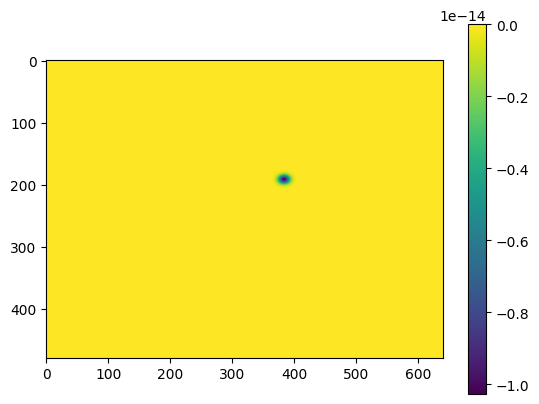

In [19]:
plt.imshow(WeightMeshX[2].cpu())
plt.colorbar()

In [20]:
InterpolatedFlowX[400, 200]

tensor(1.0325e-14, device='cuda:0', dtype=torch.float64)

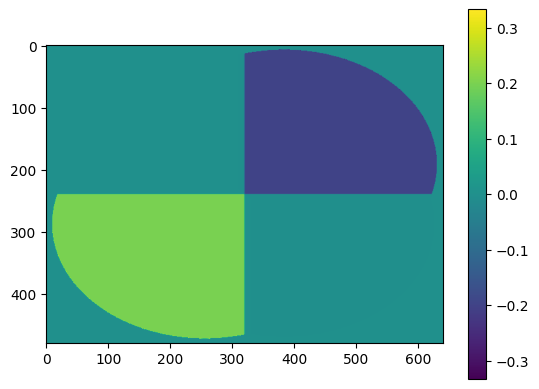

In [21]:
torch.sum(MeshE, dim=0).shape
# plt.imshow(torch.sum(MeshE, dim=0).cpu())
# plt.colorbar()

# plt.imshow(MeshE[2].cpu())
# plt.colorbar()

plt.imshow(InterpolatedFlowY.cpu())
plt.colorbar()

In [22]:
d1 = torch.linspace(-1, 1, height)
d2 = torch.linspace(-1, 1, width)
meshy, meshx = torch.meshgrid(d1, d2, indexing='ij')
# meshx, meshy = meshx.to(DEVICE), meshy.to(DEVICE)

meshx = meshx.clone().detach().to(DEVICE)
meshy = meshy.clone().detach().to(DEVICE)

meshx = meshx - X
meshy = meshy - Y
grid = torch.stack((meshy, meshx), 2)
grid = grid.unsqueeze(0)
#img = torch.tensor(img, dtype=torch.float, device=DEVICE)
img = refImg.float().to(DEVICE)
img = torch.unsqueeze(img, 0)
# grid = torch.tensor(grid, dtype=torch.float)
grid = grid.float()
output = torch.nn.functional.grid_sample(img, grid, padding_mode="border",align_corners=True)

In [23]:
meshy

tensor([[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-0.9958, -0.9958, -0.9958,  ..., -0.9958, -0.9958, -0.9958],
        [-0.9916, -0.9916, -0.9916,  ..., -0.9916, -0.9916, -0.9916],
        ...,
        [ 0.9916,  0.9916,  0.9916,  ...,  0.9916,  0.9916,  0.9916],
        [ 0.9958,  0.9958,  0.9958,  ...,  0.9958,  0.9958,  0.9958],
        [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000]],
       device='cuda:0', dtype=torch.float64)

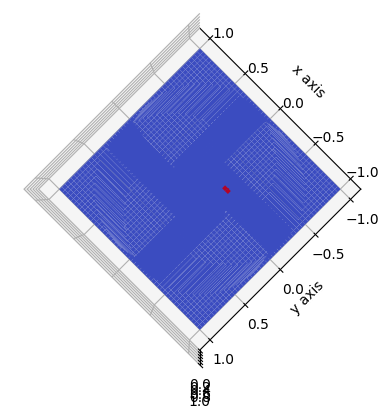

In [24]:

ax = plt.axes(projection='3d')
ax.plot_surface(meshx.cpu().numpy(), meshy.cpu().numpy(), (output.squeeze().squeeze()).cpu().numpy(), cmap=cm.coolwarm)
plt.xlabel("x axis")
plt.ylabel("y axis")
ax.view_init(90, 130)
plt.show()

In [25]:
import numpy as np
import scipy.io
tmp = {}
tmp['data'] = (output.squeeze().squeeze()).cpu().numpy()

scipy.io.savemat('test.mat', tmp)

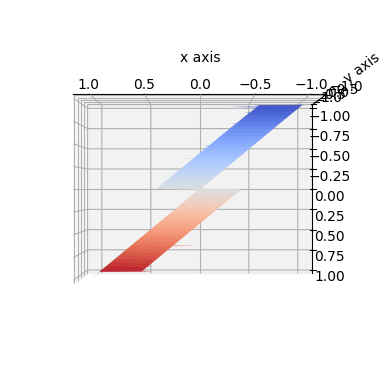

In [26]:

ax = plt.axes(projection='3d')
ax.plot_surface(meshx.cpu().numpy(), meshy.cpu().numpy(), (meshx + X).cpu().numpy(), cmap=cm.coolwarm)
plt.xlabel("x axis")
plt.ylabel("y axis")
ax.view_init(180, 90)
plt.show()

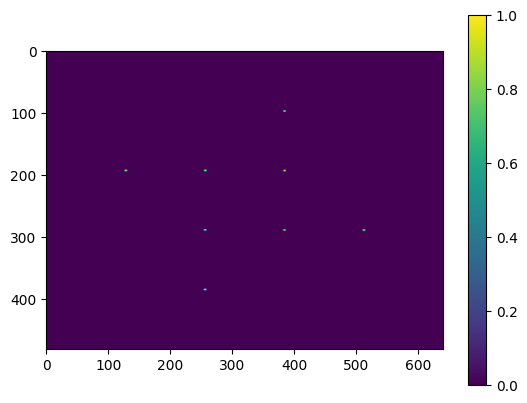

In [27]:
plt.imshow(output.squeeze().squeeze().cpu())
plt.colorbar()

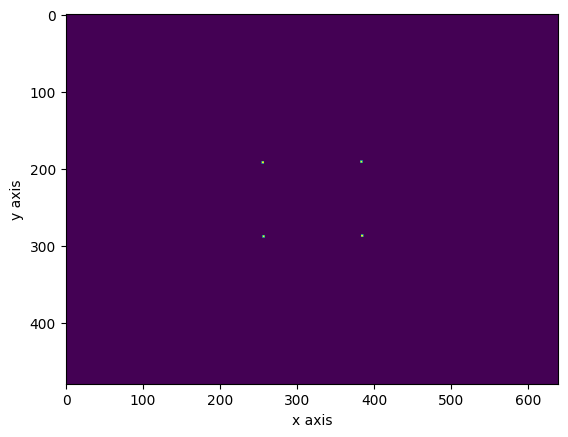

In [28]:
tarMask = createMask2(newKeys, height, width)
tarMask = showImageTensor(tarMask, is3chan=False, returnOutput=True)

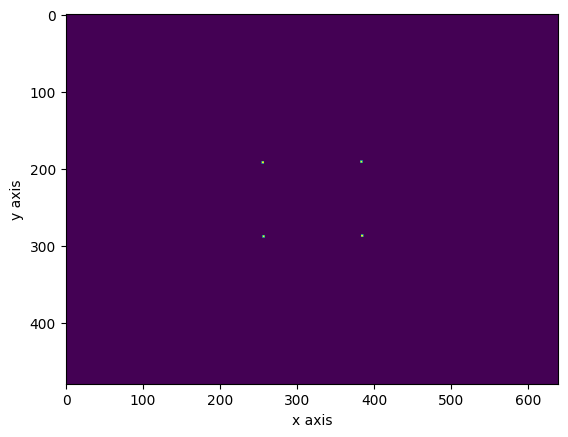

In [29]:
refMask = createMask2(refKey, height, width)
refImg = showImageTensor(refMask, is3chan=False, returnOutput=True)
refImg = torch.unsqueeze(refImg, 0) # Adding the channel dimension to the data

tarMask = createMask2(newKeys, height, width)
tarMask = showImageTensor(tarMask, is3chan=False, returnOutput=True)
tarMask = torch.unsqueeze(tarMask, 0) # Adding the channel dimension to the data


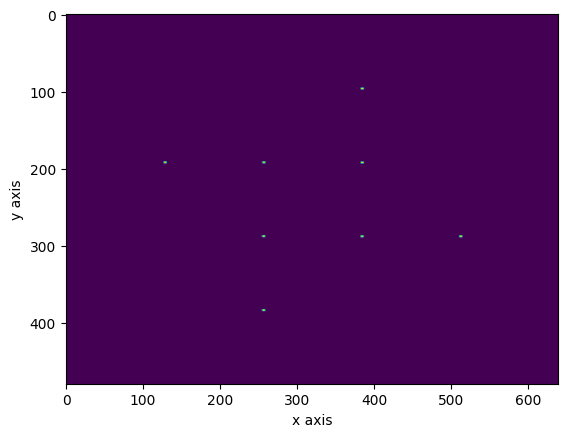

In [30]:
output = RenderImage(height, width, refKey, newKeys, refImg, sd=0.01, distMethod="gaussian")
dummy = torch.squeeze(output)
showImageTensor(dummy, is3chan=False, isOutput=True, returnOutput=False)

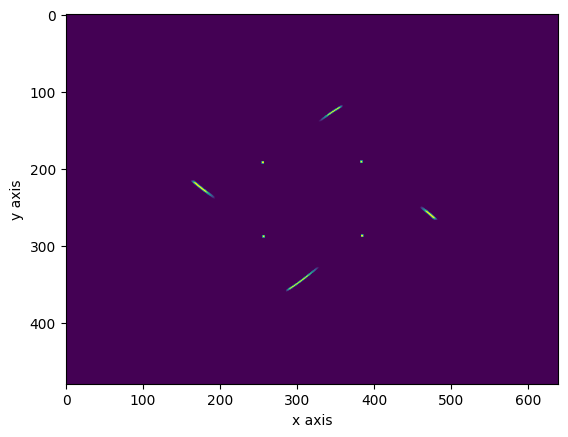

In [15]:
frameSize = (640, 480)

# out = cv2.VideoWriter('BlackWhite.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 10, frameSize)


T = torch.tensor([0.0, 0.0, 0.0], device=DEVICE)
# T = -torch.mean(refKey, axis=0) + torch.tensor([0.5, 0.5, 0], device=DEVICE)

i = 0
j = 0
k = 90

# for k in range(-45, 46):
# j = 90
euler = torch.tensor([i * pi / 180, j * pi / 180, k * pi / 180], device=DEVICE, dtype=torch.double)
newKeys = TransformKeys(refKey, euler, T)

refMask = createMask2(refKey, height, width)
refImg = showImageTensor(refMask, is3chan=False, returnOutput=True)
refImg = torch.unsqueeze(refImg, 0) # Adding the channel dimension to the data

tarMask = createMask2(newKeys, height, width)
tarImg = showImageTensor(tarMask, is3chan=False, returnOutput=True)
tarImg = torch.unsqueeze(tarImg, 0) # Adding the channel dimension to the data

output = RenderImage(height, width, refKey, newKeys, refImg, sd=0.1, distMethod="gaussian")
dummy = torch.squeeze(output)


img = showImageTensor(dummy, is3chan=False, isOutput=True, returnOutput=True)
t = tarImg.squeeze().to(DEVICE)
img = t + dummy# + refImg.squeeze().to(DEVICE)
kk =showImageTensor(img, is3chan=False, isOutput=True, returnOutput=True)
    
    # kk = np.moveaxis(np.uint8(kk.cpu()*255), 0, -1)
    # out.write(kk)


# out.release()